# HW3: Hamiltonian Monte Carlo


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Jake Taylor

**Names of any collaborators:** _Names here_

*Due: 11:59pm Friday, April 23, 2021 via GradeScope*

---

In this homework assignment you'll perform MCMC with both Metropolis-Hastings Hamiltonian Monte Carlo. We will investigate the Federalist papers---specifically, modeling the rate at which Hamilton (we're using HMC after all!) uses the word _can_ in his papers. 

We will fit this model using a negative binomial distribution. That is, for each document $n$ that Hamilton wrote, we have the number of times the word 'can' appears $y_n$ as 
\begin{align}
y_n \sim \text{NB}(\mu_n, r)
\end{align}
where 
\begin{align}
\text{NB}(y_n \mid \mu_n, r) = \frac{\Gamma(y_n+r)}{\Gamma(r) \Gamma(y_n+1)} \left(\frac{r}{\mu_n + r}\right)^r \left(1 - \frac{r}{\mu_n + r}\right)^{y_n}
\end{align}
The mean is given by $\mathbb{E}[y_n] = \mu_n$, and $r$ controls the dispersion. Here, we model the mean for document $n$ as
\begin{align}
\mu_n = \frac{T_n}{1000} \mu
\end{align}
where $\mu$ is the rate of usage of 'can' per 1000 words and $T_n$ is the number of words in document $n$ (i.e. the document length).

For our model, we will use the following prior for the non-negative parameters,
\begin{align}
\log \mu &\sim \mathcal{N}(0, 9) \\
\log r &\sim \mathcal{N}(0, 9)
\end{align}

In a classic paper, Mosteller and Wallace (JASA, 1963) used likelihood ratios under negative binomial models with different mean rates for Alexander Hamilton and James Madison to infer the more likely author of disputed Federalist papers. Spoiler alert: while Hamilton wrote the majority of the papers, the 12 disputed papers appear to be Madison's! A key step in their analysis was estimating the NB parameters. While Mosteller and Wallace used a point estimate for each word and author, you'll do full posterior inference, focusing on Hamilton's use of the word _can_.


In [286]:
!wget -nc https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw3/federalist_can_hamilton.csv

zsh:1: command not found: wget


In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.stats import multivariate_normal, bernoulli
import autograd.numpy as np
import autograd.scipy.stats as ss
import autograd.scipy.special as sp
from autograd import grad
from autograd.misc import flatten
from tqdm import tqdm

# Load the data
df = pd.read_csv("federalist_can_hamilton.csv")
Ts = np.array(df["Total"])
ys = np.array(df["N"])
# preview data
list(zip(ys, Ts))[:5]

[(3, 1622), (5, 2511), (2, 2171), (4, 970), (14, 3095)]

$\pagebreak$

## Problem 1  [math]: Show that the negative binomial can be expressed as the marginal distribution of a Poisson with gamma prior

Similar to how the Student's t distribution is a marginal of an inverse chi-squared and a Gaussian, show that

\begin{align}
\text{NB}(y \mid \mu, r) = \int \text{Po}(y \mid \lambda) \, \text{Ga}(\lambda \mid \alpha,\beta) \, \mathrm{d}\lambda
\end{align}

Express the parameters of the negative binomial distribution as a function of the parameters of the gamma distribution. (Assume $\beta$ is the rate parameter.)  
\begin{gather*}
\int Po(y | \lambda) Ga(\lambda | \alpha, \beta) d\lambda = \int \frac{\lambda^y e^{-y}}{y!}\frac{\lambda^{\alpha-1}e^{\beta\lambda}}{\beta^{-\alpha}\Gamma(\alpha)}d\lambda \\
=\frac{\beta^\alpha}{\Gamma(y+1)\Gamma(a)}\int \lambda^{\alpha + y - 1}e^{-\lambda(1 + \beta)} d\lambda\\
x = \lambda(1 + \beta),\frac{dx}{d\lambda} = (1+\beta),  z = \alpha + y\\
= \frac{\beta^\alpha}{\Gamma(y+1)\Gamma(a)}\int (\frac{x}{1 + \beta})^{\alpha + y - 1}e^{-x}d\lambda \frac{dx}{d\lambda} (1+\beta)^{-1}\\
=\frac{\beta^\alpha}{\Gamma(y+1)\Gamma(a)} (1 + \beta)^{-z + 1}(1 + \beta)^{-1}\int x^{z-1}e^{-x}dx\\
= \frac{\Gamma(\alpha + y)}{\Gamma(y+1)\Gamma(a)} \beta^\alpha (1 + \beta)^{-(\alpha + y)}\\
= \frac{\Gamma(\alpha + y)}{\Gamma(y+1)\Gamma(a)} \beta^\alpha (\frac{1}{1+\beta})^\alpha(\frac{1}{1+\beta})^y\\
\fbox{$\alpha = r$}, \frac{1}{1+\beta} = 1 - \frac{r}{\mu+ r} = \frac{\mu}{\mu + r} \implies \fbox{$\beta = \frac{r}{\mu}$}\\
= \frac{\Gamma(r + y)}{\Gamma(y+1)\Gamma(r)} (\frac{r}{\mu})^r (\frac{\mu}{\mu + r})^r(1 - \frac{r}{\mu+ r})^y \\
= \frac{\Gamma(r + y)}{\Gamma(y+1)\Gamma(r)} (\frac{r}{\mu + r})^r (1 - \frac{r}{\mu+ r})^y \\
= NB(y | \mu, r)\\
\implies r = \alpha, \mu = \frac{\alpha}{\beta}
\end{gather*}

$\pagebreak$

## Problem 2: Implement the log joint probability of the model

In [17]:
import autograd.numpy as np


def log_joint(log_mu, log_r, ys=ys, Ts=Ts):
    N = len(ys)
    mu = np.exp(log_mu)
    r = np.exp(log_r)
    mus = (Ts / 1000.0) * mu
    p = r / (mus + r)
    likelihood = (
        np.sum(np.log(sp.gamma(ys + r)))
        - np.sum(np.log(sp.gamma(ys + 1)))
        - N * np.log(sp.gamma(r))
        + np.sum(ys * np.log(1 - p))
        + np.sum(r * np.log(p))
    )
    # likelihood = np.sum(ss.nbinom.logpmf(ys, n=r, p=p))
    r_prior = ss.norm.logpdf(log_r, 0.0, 3.0)
    mu_prior = ss.norm.logpdf(log_mu, 0.0, 3.0)
    return likelihood + r_prior + mu_prior

In [3]:
log_joint(ys=ys, Ts=Ts, log_mu=0, log_r=0)

-169.40747146591295

For the following MC implementation problems, sample in $\log(\mu), \log(r)$ space. Initialize with $\log(\mu) = 0, \log(r) = 0$.

$\pagebreak$

## Problem 3: Implement Metropolis-Hastings

Implement and run Metropolis-Hastings with a spherical Gaussian proposal. Try various proposal variances.

In [4]:
def metropolis(log_mu=0, log_r=0, q_sigma=0.1, iterations=5000, lik=log_joint):
    """MCMC approximate inference"""
    theta = [log_mu, log_r]
    cache = [theta]
    for i in range(iterations):
        # proposal step
        theta_prime = multivariate_normal.rvs(
            mean=theta, cov=np.diag([q_sigma] * 2), size=1
        )

        # accept/ reject step
        A = np.exp(lik(theta_prime[0], theta_prime[1]) - lik(theta[0], theta[1]))
        a = np.min([1.0, A])
        if bernoulli.rvs(p=a) == 1:
            theta = theta_prime
        cache.append(theta)
    return np.array(cache)

In [291]:
mcmc = metropolis()

$\pagebreak$


## Problem 4: Implement Hamiltonian Monte Carlo

Implement the leapfrog step as a function, and run HMC. Try various step sizes and number of leapfrog steps.

In [42]:
def hamiltonian(
    log_mu=0.0,
    log_r=0.0,
    epsilon=0.01,
    iterations=5000,
    leapfrog_steps=40,
    func=log_joint,
):
    """HMC approximate inference"""
    np.random.seed(seed=271)

    # Setup gradient function
    q, unflatten = flatten([log_mu, log_r])

    def U(params):
        return -func(*unflatten(params))

    def K(params):
        return np.sum(np.power(params, 2)) / 2

    grad_U = grad(U)
    current_q = q
    cache_q = []
    cache_H = []
    cache_p = []
    for _ in tqdm(range(iterations)):
        # proposal step
        p = multivariate_normal.rvs(mean=[0, 0], cov=np.diag([1, 1]), size=1)
        current_p = p

        # First half step
        p = p - epsilon * grad_U(q) / 2

        # Alternate full steps for position and momentum
        for j in range(leapfrog_steps):
            q = q + epsilon * p
            if j != leapfrog_steps - 1:
                # Full step when not at end of trajectory
                p = p - epsilon * grad_U(q)

            cache_q.append(q)
            cache_p.append(p)
            cache_H.append(U(q) + K(p))

        # half step for momentum at end
        p = p - epsilon * grad_U(q) / 2

        # negate p to make proposal symmetric
        p = -p

        current_U = U(current_q)
        current_K = K(current_p)
        proposed_U = U(q)
        proposed_K = K(p)

        # accept/ reject step
        A = np.exp(current_U - proposed_U + current_K - proposed_K)
        a = np.min([1.0, A])
        if bernoulli.rvs(p=a) == 1:
            current_q = q
    return np.array(cache_q), np.array(cache_p), np.array(cache_H)

In [48]:
hmc, p, H = hamiltonian(iterations=100, leapfrog_steps=100)
q = hmc

100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


$\pagebreak$

In [50]:
# import numpy as np
import pandas as pd
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px


def kde(p, q, points):
    """Plot the kernel density of a pair of vectors.

    Args:
        p: The momentum vector.
        q: The position vector.
        points: Number of points along each edge of the grid.

    Returns:
        The momentum edges, position edges, and grid of kde values.
    """
    xmin, xmax = p.min(), p.max()
    ymin, ymax = q.min(), q.max()
    x = np.linspace(xmin, xmax, points)
    y = np.linspace(ymin, ymax, points)
    X, Y = np.meshgrid(x, y)
    kernel = stats.gaussian_kde(np.vstack([p, q]))
    Z = np.reshape(kernel(np.vstack([X.ravel(), Y.ravel()])).T, X.shape)
    return x, y, Z


def plot_hamiltonian(p, q, H, contours=20, points=100):
    """Plot the phase space of the Hamiltonian.

    Args:
        p: The momentum vector.
        q: The position vector.
        H: The Hamiltonian vector.
        contours: Number of contours rings in the KDE plot.
        points: Number of points along each edge of the grid.

    Returns:
        plotly Figure of the Hamiltonian phase space.
    """
    fig = go.Figure()
    P = np.exp(-H)
    x, y, Z = kde(p, q, points=points)
    fig.add_trace(
        go.Surface(
            x=x,
            y=y,
            # Scale the kde values to the size of the Hamiltonian.
            z=(Z / Z.max()) * max(P),
            name=f"KDE of p & q",
            opacity=0.05,
            showscale=False,
            showlegend=True,
            contours=dict(
                z=dict(
                    show=True,
                    start=min(P),
                    end=max(P),
                    size=(max(P) - min(P)) / contours,
                    project_z=True,
                    usecolormap=True,
                )
            ),
        ),
    )
    fig.add_trace(
        go.Scatter3d(
            x=p,
            y=q,
            z=P,
            opacity=0.1,
            name=f"Samples for p & q",
            mode="markers",
            marker=dict(
                size=2,
                color=P,
            ),
        ),
    )
    fig.update_layout(
        autosize=True,
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=True,
        legend=dict(yanchor="bottom", y=-10.0, xanchor="left", x=0.01),
        scene=dict(
            xaxis=dict(title="p"),
            yaxis=dict(title="q"),
            zaxis=dict(title="H"),
        ),
    )
    return fig


# NOTE: p, q, & H represent the momentum, position, and Hamiltonian vectors, respectively.
# p = np.array([])
# q = np.array([])
# H = np.array([])

# Plot Hamiltonian value
fig = px.line(
    pd.DataFrame({"Iteration": range(len(H)), "Hamiltonian Value": H}),
    x="Iteration",
    y="Hamiltonian Value",
)
fig.write_html(
    "/Users/jakeetaylor/jakee417.github.io/_includes/hamiltonian_value.html",
    include_plotlyjs="cdn",
)
fig.show()

# Phase Space Plots
fig = plot_hamiltonian(p[:, 0], q[:, 0], H)
fig.write_html(
    f"/Users/jakeetaylor/jakee417.github.io/_includes/hamiltonian_{0}.html",
    include_plotlyjs="cdn",
)
fig.show()
fig = plot_hamiltonian(p[:, 1], q[:, 1], H)
fig.write_html(
    f"/Users/jakeetaylor/jakee417.github.io/_includes/hamiltonian_{1}.html",
    include_plotlyjs="cdn",
)
fig.show()

## Problem 5: Diagnostics

For both algorithms, make trace plots of the parameters and plot histograms of posterior marginals.

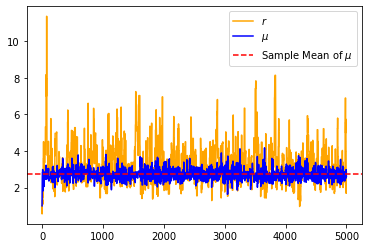

In [47]:
plt.plot(np.exp(mcmc[:,1]), color = 'orange',  label = r'$r$')
plt.plot(np.exp(mcmc[:,0]), color = 'blue', label = r'$\mu$')
plt.axhline((df.N * 1000 / df.Total).mean(),
            color='red', 
            ls='--',
            label=r'Sample Mean of $\mu$')
plt.legend()
plt.show()

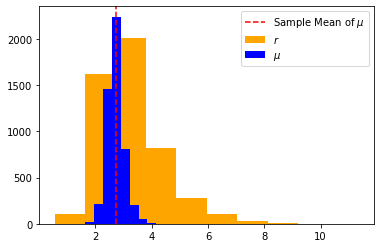

In [48]:
plt.hist(np.exp(mcmc[:,1]), color='orange', label = r'$r$')
plt.hist(np.exp(mcmc[:,0]), color='blue', label = r'$\mu$')
plt.axvline((df.N * 1000 / df.Total).mean(), color='red', ls='--', label=r'Sample Mean of $\mu$')
plt.legend()
plt.show()

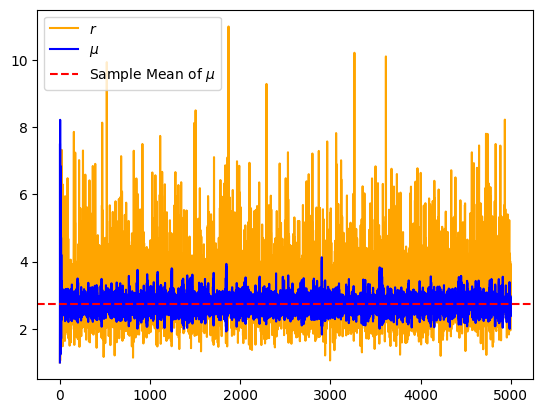

In [14]:
plt.plot(np.exp(hmc[:,1]), color = 'orange',  label = r'$r$')
plt.plot(np.exp(hmc[:,0]), color = 'blue', label = r'$\mu$')
plt.axhline((df.N * 1000 / df.Total).mean(),
            color='red', 
            ls='--',
            label=r'Sample Mean of $\mu$')
plt.legend()
plt.show()

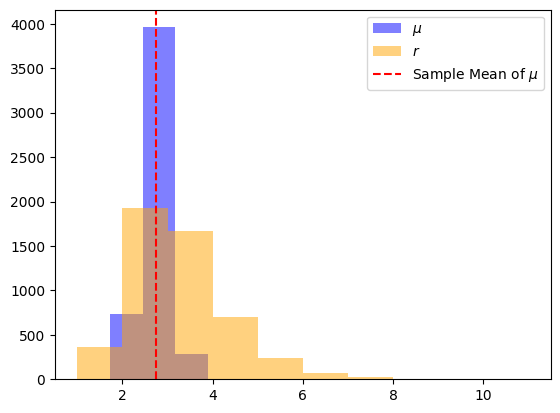

In [15]:
plt.hist(np.exp(hmc[:,0]), color='blue', alpha = 0.5, label = r'$\mu$')
plt.hist(np.exp(hmc[:,1]), color='orange', alpha = 0.5, label = r'$r$')
plt.axvline((df.N * 1000 / df.Total).mean(), color='red', ls='--', label=r'Sample Mean of $\mu$')
plt.legend()
plt.show()

$\pagebreak$

## Problem 6: Effective Sample Size

Calculate effective sample size for both chains.

In [2]:
import tensorflow_probability as tfp

In [68]:
ess = tfp.mcmc.effective_sample_size(mcmc, filter_beyond_positive_pairs=True)
print(ess.numpy())

[872.2407521 281.1380704]


In [67]:
ess = tfp.mcmc.effective_sample_size(hmc, filter_beyond_positive_pairs=True)
print(ess.numpy())

[30805.45300581  2584.27555287]


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw3_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
